In [1]:
from brian2 import *
import efel

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import time 
import pandas as pd
import pyabf
import os
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit, minimize, differential_evolution
import time
import seaborn as sns

%matplotlib notebook

In [3]:
# finding stds of parameters for cost normalization
df1 = pd.read_csv('features.csv')
df1 = df1.groupby('input_current').std()
df1 = df1.reset_index()
_ = np.array(df1.values.tolist())
stds = _[3:, 2:] # considering only positive input traces
stds[:,0] = 1 # to avoid devide by zero for weights=1/std (not a feature to be used)
weights = 1/stds * np.array([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1]) # features that are used

df2 = pd.read_csv('features2.cvs')
df2 = df2.groupby(['group', 'cell_name']).mean().reset_index()
df4 = df2.drop(columns=['Unnamed: 0', 'input_current', 'sweep'])
df4.head()

,group,cell_name,f_rate,t_last_spike,R,Tau,rest_potential
0,Goal DLS,20181208_DLS_s1c1_0000.abf,87.731409,208.755556,116.7270,7.42724,-85.259546
1,Goal DLS,20181208_DLS_s1c2_0000.abf,93.920154,340.011111,162.0890,6.85265,-81.130003
2,Goal DLS,20181212_DLS_s1c1_0000.abf,118.418603,214.275000,114.9590,8.77209,-80.017245
3,Goal DLS,20181212_DLS_s2c1_0000.abf,144.972950,225.611111,93.2183,5.58183,-79.338625
4,Goal DLS,20181213_DLS_s1c1_0000.abf,190.647789,208.210000,208.2450,8.58692,-81.748753


In [4]:
def cell_params(cell_id, features=df4, plot=True):
    
    # extracting cell properties
    cell_name = df4.iloc[cell_id]['cell_name']
    group = df4.iloc[cell_id]['group']
    filename = 'FSI Current Injection Data/FSI Current Injection Data/' + group +'/' + cell_name
    R = df4.iloc[cell_id]['R']
    tm = df4.iloc[cell_id]['Tau']
    EL = df4.iloc[cell_id]['rest_potential']
        
    return(filename, tm, EL, R,)

def inputOutputAll(cellfilename):
    
    dt = 0.1*ms

    def inputOutput(cellfilename, sweepnum):

        abf = pyabf.ABF(cellfilename)
        abf.setSweep(sweepnum)
        V = abf.sweepY
        Ix = abf.sweepC
        #t = abd.sweepX*1000

        if sweepnum!=2 and np.abs(Ix[4000])<10:
            abf = pyabf.ABF(cellfilename)
            abf.setSweep(sweepnum, channel=1)
            Ix = abf.sweepC

        return(Ix, V)

    for sweep in range(3,13): ## choose traces to be considered
        (Ix, V) = inputOutput(cellfilename, sweep)
        i_stim = np.argmax(np.abs(Ix))
        i_end = len(Ix) - np.argmax(np.abs(Ix[::-1]))
        if sweep==3:
            inp_trace = np.array([Ix])
            out_trace = np.array([V])
            stim_time = [(i_stim*dt, i_end*dt)]
        else:
            inp_trace = np.append(inp_trace, [Ix], axis=0)
            out_trace = np.append(out_trace, [V], axis=0)
            stim_time.append((i_stim*dt, i_end*dt))
            
    return(inp_trace, out_trace, stim_time)


def extract_features(inp_trace, out_trace):

    # inp_trace and out_trace from inputOutputAll: (n_traces, n_time_steps) 
    
    # outputs
    # 0- input current (pA)
    # 1-rest potential before current (mV)
    # 2-average potential during stim (mV)
    # 3-time to first spike (ms)
    # 4-time to the last spike (ms)
    # 5-average spike frequency (Hz)
    # 6-AP amplitude (mV)
    # 7-AP adaptation index (ms)
    # 8- average spike rise slope (mV/ms)
    # 9-average time to after spike hyperpolarization (ms)
    # 10-average after spike hyperpolarization depth (mV)
 
    dt = 0.1
    ################### subroutines ####################
    def find_spikes(V, thr):

        i_max = np.array(argrelextrema(V, np.greater))[0]
        i_max = i_max[V[i_max]>thr]
        return(i_max)

    def find_deeps(V, thr):

        i_max = find_spikes(V, thr)
        if len(i_max)<1:
            return(np.array([]), np.array([]))

        i_min = np.zeros_like(i_max[:-1])
        v_min = np.zeros_like(i_max[:-1])
        for ind in range(len(i_max)-1):

            start = i_max[ind]
            end = i_max[ind+1]
            _i_min = np.argmin(V[start:end])
            _v_min = np.min(V[start:end])
            i_min[ind] = _i_min
            v_min[ind] = _v_min

        return(i_min, v_min)

    def exp_fit(x, a, c, d):
        return a*np.exp(-x/c)+d
    
    ################### main routine #######################
    f_trace = []
    for n_tr in range(inp_trace.shape[0]):
        
        Ix = inp_trace[n_tr, :]
        V = out_trace[n_tr, :]
        t = np.arange(0, len(Ix)*dt, dt)
        
        # input
        f0 = Ix[4000]

        # potentials
        i_stim = np.argmax(np.abs(Ix))
        i_end = len(Ix) - np.argmax(np.abs(Ix[::-1]))
        if i_stim>1:
            f1 = np.mean(V[:i_stim]) # rest potential before current (mV)
            f2 = np.mean(V[i_stim:i_end]) # average potential during stim (mV)
        else:
            f1 = np.mean(V)
            f2 = np.mean(V)

        if np.isnan(V[-1]): return([f0,f1]+[np.nan]*9) # in case of overflow in simulations

        # spikes
        thr = f2+10 # threshold for spike detection (mV)
        i_max = find_spikes(V, thr=thr)
        i_max = i_max[(i_max>i_stim) & (i_max<i_end)]

        if len(i_max)>2:
            f3 = t[i_max[0]]-t[i_stim] # time to first spike (ms)
            f4 = t[i_max[-1]]-t[i_stim] # time of the last spike (ms)
            f5 = len(i_max-1)/(t[i_max[-1]]-t[i_max[0]]) * 1000 # average spike frequency (Hz)
            #x = t[i_max]-t[i_max[0]]
            #y = V[i_max]
            #p, cov = curve_fit(exp_fit, x, y, p0=(10, 100, 30), bounds=((0, 0, -100), (100, 10000, 100)))
            #f6 = p[0]+p[2] # AP amplitude (mV)
            f6 = V[i_max].mean()
            #f7 = p[1]  # AP adaptation index (ms)
            f7 = 10000.
            rslopes = (V[i_max]-V[i_max-4])/(t[4]-t[0])
            f8 = np.mean(rslopes) # average spike rise slopes (mV/ms)
        else:
            f3, f4, f5, f6, f7, f8 = 50., 500., 0., f2, 10000., 0.

        i_min, v_min = find_deeps(V, thr)
        if len(i_min)>1:
            f9 = np.mean(t[i_min]) # time to after spike hyperpolarization (ms)
            f10 = np.mean(v_min) # after spike hyperpolarization depth (mV)
        else:
            f9, f10 = 0., f2

        f = [f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10]

        f_trace.append(f)
        
    return(np.array(f_trace))

## Optimization

### model

In [7]:
cell_id = 20

def cost_features(x):
    # x = (g_na, g_k, ENa, EK)
    
    # experiments parameters and traces
    (filename, tm, EL, R) = cell_params(cell_id)
    (inp_trace, data_trace, stim_times) = inputOutputAll(filename)

    # defining parameters
    dt = 0.1*ms
    duration = inp_trace.shape[1]*dt
    R = R*Mohm
    tm = tm*ms
    El = EL*mV
    g_na = x[0]
    g_k = x[1]
    ENa = x[2]*mV
    EK = x[3]*mV
    
    # model
    model = Equations('''
    dv/dt = 1/tm * (-(v-El) - g_na*(m*m*m)*h*(v-ENa) - g_k*(n*n)*(v-EK) + stimulus(t,i)*R) : volt
    dm/dt = 40.*13/exprel((75.*mV-v)/(13.*mV))/ms * (1.-m) - 1/exp(v/(40.*mV))/ms * m : 1
    dh/dt = 0.0035/exp(v/(24.*mV))/ms * (1.-h) - 0.017*5/exprel(-(50.*mV+v)/(5.*mV))/ms * h : 1
    dn/dt = 11./exprel((95.*mV-v)/(11.*mV))/ms * (1.-n) - 0.025/exp(v/(22.*mV))/ms * n : 1
    ''')
    
    # run simulations in parallel for all sweeps
    start_scope()
    sweeps = range(10)
    sweep_dict = dict(zip(range(10), np.arange(200, 2001, 200)))
    N = len(sweeps)
    P = NeuronGroup(N, model,
                threshold='v > 0*mV',
                refractory='v > 0*mV',
                method='exponential_euler')
    P.v = El
    stimulus = TimedArray(inp_trace.transpose()*pamp, dt=0.1*ms)
    trace = StateMonitor(P, 'v', record=range(N))
    run(duration)
    model_trace = trace.v/mV
    
    # extracting features and calculating cost
    f_model = extract_features(inp_trace, model_trace) 
    f_data = extract_features(inp_trace, data_trace)
    f_diff = np.abs(f_model - f_data)
    features = np.sum(np.array(f_diff)*weights, axis=1) # summing over different features (weights defined outside the function)
    error = features.mean(axis=0) # averaging over sweeps
    
    return(error)

def cost_features_vec(x):
    # x[:,i] = (g_na, g_k, ENa, EK)
    # input x array(N, S) where N is number of parameters to be optimized and S is number of sets of those params
    
    # experiments parameters and traces
    (filename, tm, EL, R) = cell_params(cell_id)
    (inp_trace, data_trace, stim_times) = inputOutputAll(filename)

    # defining parameters
    dt = 0.1*ms
    duration = inp_trace.shape[1]*dt
    R = R*Mohm
    tm = tm*ms
    El = EL*mV
    g_na = x[0]
    g_k = x[1]
    ENa = x[2]*mV
    EK = x[3]*mV
    
    sweeps = range(10)
    sweep_dict = dict(zip(range(10), np.arange(200, 2001, 200)))
    N = len(sweeps)
    S = len(g_na)
    stimulus = TimedArray(inp_trace.transpose()*pamp, dt=0.1*ms)
    
    # model
    model = Equations('''
    dv/dt = 1/tm * (-(v-El) - g_na(i//N)*(m*m*m)*h*(v-ENa(i//N)) - g_k(i//N)*(n*n)*(v-EK(i//N)) + stimulus(t,i%N)*R) : volt
    dm/dt = 40.*13/exprel((75.*mV-v)/(13.*mV))/ms * (1.-m) - 1/exp(v/(40.*mV))/ms * m : 1
    dh/dt = 0.0035/exp(v/(24.*mV))/ms * (1.-h) - 0.017*5/exprel(-(50.*mV+v)/(5.*mV))/ms * h : 1
    dn/dt = 11./exprel((95.*mV-v)/(11.*mV))/ms * (1.-n) - 0.025/exp(v/(22.*mV))/ms * n : 1
    ''')
    
    # run simulations in parallel for all sweeps
    start_scope()
    P = NeuronGroup(N*S, model,
                threshold='v > 0*mV',
                refractory='v > 0*mV',
                method='exponential_euler')
    P.v = El
    trace = StateMonitor(P, 'v', record=range(N))
    run(duration)
    model_trace = trace.v/mV
    
    # extracting features and calculating cost
    f_model = extract_features(np.tile(inp_trace, x.shape[1]), model_trace) 
    f_data = extract_features(inp_trace, data_trace)
    f_diff = np.abs(f_model - np.tile(f_data, x.shape[1]))
    features = np.sum(np.array(f_diff)*weights, axis=1) # summing over different features (weights defined outside the function)
    error = features.reshape((len(sweeps), x.shape[1])).mean(axis=0) # averaging over sweeps
    
    return(error)


In [56]:
start_t = time.time()
cost_features([300,300,50,-90])
print('time spent: ', time.time()-start_t, 's')

time spent:  1.2665798664093018 s


In [8]:
start_t = time.time()
cost_features_vec([[300],[300],[50],[-90]])
print('time spent: ', time.time()-start_t, 's')

BrianObjectException: Error encountered with object named "neurongroup_1".
Object was created here (most recent call only, full details in debug log):
  File "<ipython-input-7-b1d2b91f6d4d>", line 91, in cost_features_vec
    method='exponential_euler')

An error occurred when preparing an object. (See above for original error message and traceback.)

### optimizer

In [51]:
bounds=([1,2000], [1,2000], [10,100], [-120,-70])

start_t = time.time()

result = differential_evolution(
                                cost_features, 
                                bounds,  
                                maxiter=5, 
                                popsize=10,
                                disp=True,
                                workers=-1)

print('time spent: ', time.time()-start_t, 's')
print('values:', result.x, 'cost:', result.fun)
res = dict(zip(['g_na', 'g_k', 'ENa', 'EK'], result.x))

WARNING    /home/agheal/.local/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:497: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)
 [py.warnings]
WARNING    /home/agheal/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
WARNING    /home/agheal/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
WARNING    /home/agheal/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
WARNING    /home/agheal/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance

differential_evolution step 1: f(x)= 4.91195
differential_evolution step 2: f(x)= 4.65509


WARNING    /home/agheal/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]


differential_evolution step 3: f(x)= 4.44506


WARNING    /home/agheal/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
WARNING    /home/agheal/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]


differential_evolution step 4: f(x)= 4.291
differential_evolution step 5: f(x)= 4.291
time spent:  231.15169620513916 s
values: [1420.2941  532.0497   21.3589  -71.7339] cost: 4.290478373408231


## plots

In [47]:
def plot_examples(cell_id, res):
    
    # experiments parameters and traces
    (filename, tm, EL, R) = cell_params(cell_id)
    (inp_trace, data_trace, stim_times) = inputOutputAll(filename)
    sweeps = [0,2,5,8]
    inp_trace = inp_trace[sweeps]
    data_trace = data_trace[sweeps]

    # defining parameters
    dt = 0.1*ms
    duration = inp_trace.shape[1]*dt
    R = R*Mohm
    tm = tm*ms
    El = EL*mV
    g_na = res['g_na']
    g_k = res['g_k']
    ENa = res['ENa']*mV
    EK = res['EK']*mV
    
    # model
    model = Equations('''
    dv/dt = 1/tm * (-(v-El) - g_na*(m*m*m)*h*(v-ENa) - g_k*(n*n)*(v-EK) + stimulus(t,i)*R) : volt
    dm/dt = 40.*13/exprel((75.*mV-v)/(13.*mV))/ms * (1.-m) - 1/exp(v/(40.*mV))/ms * m : 1
    dh/dt = 0.0035/exp(v/(24.*mV))/ms * (1.-h) - 0.017*5/exprel(-(50.*mV+v)/(5.*mV))/ms * h : 1
    dn/dt = 11./exprel((95.*mV-v)/(11.*mV))/ms * (1.-n) - 0.025/exp(v/(22.*mV))/ms * n : 1
    ''')
    
    # run simulations in parallel for all sweeps
    start_scope()
    N = len(sweeps)
    P = NeuronGroup(N, model,
                threshold='v > 0*mV',
                refractory='v > 0*mV',
                method='exponential_euler')
    P.v = El
    stimulus = TimedArray(inp_trace.transpose()*pamp, dt=0.1*ms)
    trace = StateMonitor(P, 'v', record=range(N))
    run(duration)
    model_trace = trace.v/mV
    
    
    sweep_dict = dict(zip(range(10), np.arange(200, 2001, 200)))
    plt.figure()
    for i, s in enumerate(sweeps):

        plt.subplot(2, np.ceil(len(sweeps)/2), i+1)

        # experiment
        V_exp = data_trace[i,:]
        t_exp = np.arange(0, len(V_exp)*0.1, 0.1)
        
        # model
        
        plt.plot(t_exp, V_exp, alpha=0.5) # experiment
        plt.plot(trace.t/ms, trace[i].v/mV, alpha=0.5) # model
        plt.xlabel('time (ms)')
        plt.ylabel('V (mV)')
        plt.title(f'input current: {sweep_dict[s]} pA')

    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


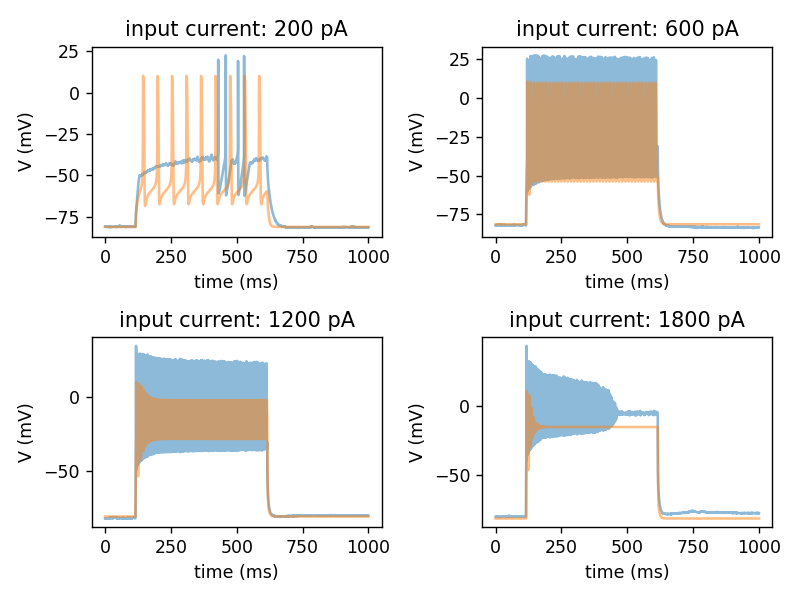

WARNING    /home/agheal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
 [py.warnings]
WARNING    /home/agheal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
 [py.warnings]
WARNING    /home/agheal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
 [py.warnings]
WARNING    /home/agheal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be remov

In [48]:
plot_examples(cell_id, res)

# Draft

In [71]:
x = np.array([[300, 300, 50, -90],[200, 200, 40, -80]])
x = x.transpose()

# experiments parameters and traces
(filename, tm, EL, R) = cell_params(cell_id)
(inp_trace, data_trace, stim_times) = inputOutputAll(filename)

# defining parameters
dt = 0.1*ms
duration = inp_trace.shape[1]*dt
R = R*Mohm
tm = tm*ms
El = EL*mV
g_na = x[0,0]
g_k = x[1,0]
ENa = x[2,0]*mV
EK = x[3,0]*mV

# model
model = Equations('''
dv/dt = 1/tm * (-(v-El) - g_na*(m*m*m)*h*(v-ENa) - g_k*(n*n)*(v-EK) + stimulus(t,i)*R) : volt
dm/dt = 40.*13/exprel((75.*mV-v)/(13.*mV))/ms * (1.-m) - 1/exp(v/(40.*mV))/ms * m : 1
dh/dt = 0.0035/exp(v/(24.*mV))/ms * (1.-h) - 0.017*5/exprel(-(50.*mV+v)/(5.*mV))/ms * h : 1
dn/dt = 11./exprel((95.*mV-v)/(11.*mV))/ms * (1.-n) - 0.025/exp(v/(22.*mV))/ms * n : 1

''')

# run simulations in parallel for all sweeps
start_scope()
sweeps = range(10)
sweep_dict = dict(zip(range(10), np.arange(200, 2001, 200)))
N = len(sweeps)
P = NeuronGroup(N, model,
            threshold='v > 0*mV',
            refractory='v > 0*mV',
            method='exponential_euler')
P.v = El
P.tm = tm
stimulus = TimedArray(inp_trace.transpose()*pamp, dt=0.1*ms)
trace = StateMonitor(P, 'v', record=range(N))
run(duration)
model_trace = trace.v/mV

# extracting features and calculating cost
f_model = extract_features(inp_trace, model_trace) 
f_data = extract_features(inp_trace, data_trace)
f_diff = np.abs(f_model - f_data)
features = np.sum(np.array(f_diff)*weights, axis=1) # summing over different features (weights defined outside the function)
error = features.mean(axis=0) # averaging over sweeps


WARNING    "tm" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 4.7462 * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [72]:
P.tm

<neurongroup_1.tm: array([4.7462, 4.7462, 4.7462, ..., 4.7462, 4.7462, 4.7462]) * msecond>

In [57]:
x = np.array([[300, 300, 50, -90],[200, 200, 40, -80]])
x = x.transpose()

# experiments parameters and traces
(filename, tm, EL, R) = cell_params(cell_id)
(inp_trace, data_trace, stim_times) = inputOutputAll(filename)

# defining parameters
dt = 0.1*ms
duration = inp_trace.shape[1]*dt
R = R*Mohm
tm = tm*ms
El = EL*mV

sweeps = range(10)
sweep_dict = dict(zip(range(10), np.arange(200, 2001, 200)))
N = len(sweeps)
S = x.shape[1]
stimulus = TimedArray(np.tile(inp_trace.transpose(), S)*pamp, dt=0.1*ms)
g_na = np.repeat(x[0], N)
g_k = np.repeat(x[1], N)
ENa = np.repeat(x[2], N)*mV
EK = np.repeat(x[3], N)*mV

# model
model = Equations('''
dv/dt = 1/tm * (-(v-El) - g_na*(m*m*m)*h*(v-ENa) - g_k*(n*n)*(v-EK) + stimulus(t,i)*R) : volt
dm/dt = 40.*13/exprel((75.*mV-v)/(13.*mV))/ms * (1.-m) - 1/exp(v/(40.*mV))/ms * m : 1
dh/dt = 0.0035/exp(v/(24.*mV))/ms * (1.-h) - 0.017*5/exprel(-(50.*mV+v)/(5.*mV))/ms * h : 1
dn/dt = 11./exprel((95.*mV-v)/(11.*mV))/ms * (1.-n) - 0.025/exp(v/(22.*mV))/ms * n : 1
''')

# run simulations in parallel for all sweeps
start_scope()
n_neurons = N*S
P = NeuronGroup(n_neurons, model,
            threshold='v > 0*mV',
            refractory='v > 0*mV',
            method='exponential_euler')
P.v = El
trace = StateMonitor(P, 'v', record=range(N))
run(duration)
model_trace = trace.v/mV

# extracting features and calculating cost
f_model = extract_features(np.tile(inp_trace, x.shape[1]), model_trace) 
f_data = extract_features(inp_trace, data_trace)
f_diff = np.abs(f_model - np.tile(f_data, x.shape[1]))
features = np.sum(np.array(f_diff)*weights, axis=1) # summing over different features (weights defined outside the function)
error = features.reshape((len(sweeps), x.shape[1])).mean(axis=0) # averaging over sweeps

BrianObjectException: Error encountered with object named "neurongroup_1".
Object was created here (most recent call only, full details in debug log):
  File "<ipython-input-57-89a03344be52>", line 39, in <module>
    method='exponential_euler')

An error occurred when preparing an object. (See above for original error message and traceback.)